# **予測された気象情報で発電量を予測**

各時点の気象情報の予測を行なってからその予測に基づいて書く時点の発電量を予測するというモデルを組みたい

モデルを組む前に書く時点の気象情報の予測力を検証する

### **必要な関数・モジュール**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [5]:
def add_month_date(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['hour', 'month'], axis=1)
    return input_data

In [6]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [7]:
# 発電量データ
all_output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
all_output_30['datetime'] = all_output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **データの準備**

In [8]:
# 予測する発電所番号を決める
target_place = 1
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [9]:
# アメダスデータの読み込み

if target_place == 1 or target_place == 2:
    # 横浜アメダスのデータを使って予測する, amd_46106
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place_num")

In [74]:
# 欠損値を一つ前の値で置換
amd_data = amd_data.fillna(method='bfill')
amd_data = get_30(amd_data)
input_data = amd_data[['datetime', 'sl']]

In [11]:
input_data = add_month_date(input_data)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [12]:
input_data.head()

,datetime,sl,month_cos,month_sin,hour_cos,hour_sin
0,2012-01-01 00:00:00,0.0,0.965926,0.258819,1.000000,0.000000
1,2012-01-01 00:30:00,0.0,0.965926,0.258819,1.000000,0.000000
2,2012-01-01 01:00:00,0.0,0.965926,0.258819,0.991445,0.130526
3,2012-01-01 01:30:00,0.0,0.965926,0.258819,0.991445,0.130526
4,2012-01-01 02:00:00,0.0,0.965926,0.258819,0.965926,0.258819


In [13]:
train_s_idx = input_data[input_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_e_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

In [14]:
X_df= input_data[['sl', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']]
X = np.array(X_df[train_s_idx:train_e_idx+1])

In [15]:
Y = np.array(output_30['SOLA0'+str(target_place)][train_s_idx:train_e_idx+1])

In [16]:
# Yの値がNanの組みを除外
X, Y = drop_nan(X, Y)

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.33)

### **とりあえずrandom forestで**

In [18]:
# ランダムフォレストリグレッサー
max_depths = [2,3,4,5,6,7,8,9,10]
train_maes = []
test_maes = []
for i in max_depths:
    rf = RandomForestRegressor(n_estimators = 20, max_depth=i)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    test_maes.append(np.abs(Y_val_pred - Y_val).mean())

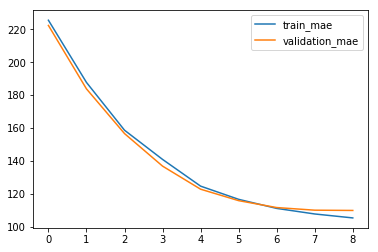

In [19]:
plt.plot(train_maes, label="train_mae")
plt.plot(test_maes, label="validation_mae")
plt.legend()

In [20]:
rf = RandomForestRegressor(n_estimators = 20, max_depth=6)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
predicted_sl = pd.read_csv('data/predicted_data/predict_sl_1.tsv', delimiter = '\t')
predicted_sl['datetime'] = predicted_sl['datetime'].map(lambda x : pd.to_datetime(x))

In [22]:
predicted_sl.columns = ['datetime', 'predicted_sl']

In [23]:
predicted_sl = add_month_date(predicted_sl)

In [24]:
predicted_sl.head()

,datetime,predicted_sl,month_cos,month_sin,hour_cos,hour_sin
0,2016-01-01 00:00:00,0.084120,0.965926,0.258819,1.000000,0.000000
1,2016-01-01 00:30:00,0.090926,0.965926,0.258819,1.000000,0.000000
2,2016-01-01 01:00:00,0.094772,0.965926,0.258819,0.991445,0.130526
3,2016-01-01 01:30:00,0.087963,0.965926,0.258819,0.991445,0.130526
4,2016-01-01 02:00:00,0.081125,0.965926,0.258819,0.965926,0.258819


In [25]:
X = predicted_sl.drop(['datetime'], axis=1)

In [26]:
prediction = rf.predict(X)

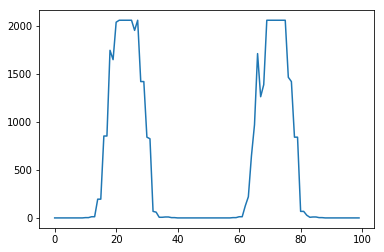

In [27]:
plt.plot(prediction[0:100])

In [28]:
prediction_df = pd.DataFrame(prediction)
prediction_df.columns = ["SOLA01"]

### **扇島**

In [29]:
# 予測する発電所番号を決める
target_place = 2
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [30]:
# アメダスデータの読み込み

if target_place == 1 or target_place == 2:
    # 横浜アメダスのデータを使って予測する, amd_46106
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place_num")

In [31]:
# 欠損値を一つ前の値で置換
amd_data = amd_data.fillna(method='bfill')
amd_data = get_30(amd_data)
input_data = amd_data[['datetime', 'sl']]

In [32]:
input_data = add_month_date(input_data)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [33]:
input_data.head()

,datetime,sl,month_cos,month_sin,hour_cos,hour_sin
0,2012-01-01 00:00:00,0.0,0.965926,0.258819,1.000000,0.000000
1,2012-01-01 00:30:00,0.0,0.965926,0.258819,1.000000,0.000000
2,2012-01-01 01:00:00,0.0,0.965926,0.258819,0.991445,0.130526
3,2012-01-01 01:30:00,0.0,0.965926,0.258819,0.991445,0.130526
4,2012-01-01 02:00:00,0.0,0.965926,0.258819,0.965926,0.258819


In [34]:
train_s_idx = input_data[input_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_e_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

In [35]:
X_df= input_data[['sl', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']]
X = np.array(X_df[train_s_idx:train_e_idx+1])

In [36]:
Y = np.array(output_30['SOLA0'+str(target_place)][train_s_idx:train_e_idx+1])

In [37]:
# Yの値がNanの組みを除外
X, Y = drop_nan(X, Y)

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.33)

### **とりあえずrandom forestで**

In [39]:
# ランダムフォレストリグレッサー
max_depths = [2,3,4,5,6,7,8,9,10]
train_maes = []
test_maes = []
for i in max_depths:
    rf = RandomForestRegressor(n_estimators = 20, max_depth=i)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    test_maes.append(np.abs(Y_val_pred - Y_val).mean())

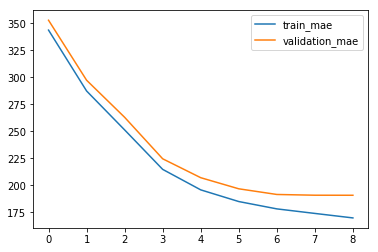

In [40]:
plt.plot(train_maes, label="train_mae")
plt.plot(test_maes, label="validation_mae")
plt.legend()

In [41]:
rf = RandomForestRegressor(n_estimators = 20, max_depth=6)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [42]:
predicted_sl = pd.read_csv('data/predicted_data/predict_sl_1.tsv', delimiter = '\t')
predicted_sl['datetime'] = predicted_sl['datetime'].map(lambda x : pd.to_datetime(x))

In [43]:
predicted_sl.columns = ['datetime', 'predicted_sl']

In [44]:
predicted_sl = add_month_date(predicted_sl)

In [45]:
predicted_sl.head()

,datetime,predicted_sl,month_cos,month_sin,hour_cos,hour_sin
0,2016-01-01 00:00:00,0.084120,0.965926,0.258819,1.000000,0.000000
1,2016-01-01 00:30:00,0.090926,0.965926,0.258819,1.000000,0.000000
2,2016-01-01 01:00:00,0.094772,0.965926,0.258819,0.991445,0.130526
3,2016-01-01 01:30:00,0.087963,0.965926,0.258819,0.991445,0.130526
4,2016-01-01 02:00:00,0.081125,0.965926,0.258819,0.965926,0.258819


In [46]:
X = predicted_sl.drop(['datetime'], axis=1)

In [47]:
prediction = rf.predict(X)

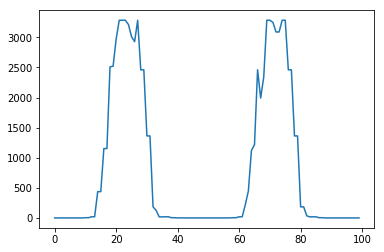

In [48]:
plt.plot(prediction[0:100])

In [49]:
prediction_df["SOLA2"] = prediction

In [50]:
prediction_df.head()

,SOLA01,SOLA2
0,0.001556,0.212211
1,0.001556,0.212211
2,0.001556,0.212211
3,0.001556,0.212211
4,0.001556,0.212211


### **米倉山**

In [51]:
# 予測する発電所番号を決める
target_place = 3
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [52]:
# アメダスデータの読み込み

if target_place == 1 or target_place == 2:
    # 横浜アメダスのデータを使って予測する, amd_46106
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place_num")

In [75]:
# 欠損値を一つ前の値で置換
amd_data = amd_data.fillna(method='bfill')
amd_data = get_30(amd_data)
input_data = amd_data[['datetime', 'sl', 'max_tp']]

In [76]:
input_data = add_month_date(input_data)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [77]:
input_data.head()

,datetime,sl,max_tp,month_cos,month_sin,hour_cos,hour_sin
0,2012-01-01 00:00:00,0.0,36.0,0.965926,0.258819,1.000000,0.000000
1,2012-01-01 00:30:00,0.0,56.0,0.965926,0.258819,1.000000,0.000000
2,2012-01-01 01:00:00,0.0,56.0,0.965926,0.258819,0.991445,0.130526
3,2012-01-01 01:30:00,0.0,39.0,0.965926,0.258819,0.991445,0.130526
4,2012-01-01 02:00:00,0.0,30.0,0.965926,0.258819,0.965926,0.258819


In [78]:
train_s_idx = input_data[input_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_e_idx = input_data[input_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

In [79]:
X_df= input_data[['sl', 'max_tp', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']]
X = np.array(X_df[train_s_idx:train_e_idx+1])

In [80]:
Y = np.array(output_30['SOLA0'+str(target_place)][train_s_idx:train_e_idx+1])

In [81]:
# Yの値がNanの組みを除外
X, Y = drop_nan(X, Y)

In [82]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.33)

### **とりあえずrandom forestで**

In [83]:
# ランダムフォレストリグレッサー
max_depths = [2,3,4,5,6,7,8,9,10]
train_maes = []
test_maes = []
for i in max_depths:
    rf = RandomForestRegressor(n_estimators = 20, max_depth=i)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    test_maes.append(np.abs(Y_val_pred - Y_val).mean())

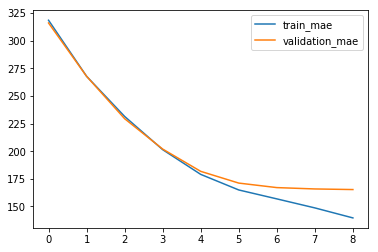

In [84]:
plt.plot(train_maes, label="train_mae")
plt.plot(test_maes, label="validation_mae")
plt.legend()

In [63]:
rf = RandomForestRegressor(n_estimators = 20, max_depth=6)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [64]:
predicted_sl = pd.read_csv('data/predicted_data/predict_sl_3.tsv', delimiter = '\t')
predicted_sl['datetime'] = predicted_sl['datetime'].map(lambda x : pd.to_datetime(x))

In [65]:
predicted_sl.columns = ['datetime', 'predicted_sl']

In [66]:
predicted_sl = add_month_date(predicted_sl)

In [67]:
predicted_sl.head()

,datetime,predicted_sl,month_cos,month_sin,hour_cos,hour_sin
0,2016-01-01 00:00:00,0.003595,0.965926,0.258819,1.000000,0.000000
1,2016-01-01 00:30:00,0.003740,0.965926,0.258819,1.000000,0.000000
2,2016-01-01 01:00:00,0.001802,0.965926,0.258819,0.991445,0.130526
3,2016-01-01 01:30:00,0.003134,0.965926,0.258819,0.991445,0.130526
4,2016-01-01 02:00:00,0.003414,0.965926,0.258819,0.965926,0.258819


In [68]:
X = predicted_sl.drop(['datetime'], axis=1)

In [69]:
prediction = rf.predict(X)

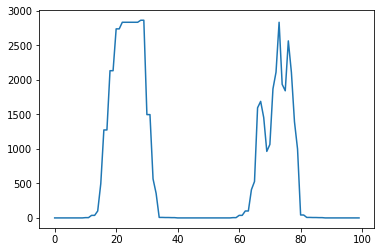

In [70]:
plt.plot(prediction[0:100])

In [71]:
prediction_df["SOLA3"] = prediction

In [72]:
prediction_df.head()

,SOLA01,SOLA2,SOLA3
0,0.001556,0.212211,0.064118
1,0.001556,0.212211,0.064118
2,0.001556,0.212211,0.064118
3,0.001556,0.212211,0.064118
4,0.001556,0.212211,0.064118


In [73]:
prediction_df.to_csv('data/predicted_data/predict_by_sl.csv', index=False)